In [1]:
import sys
import pybind11

sys.path.append("./build/")   # add build/ to Python module search path
import simulator
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit

In [2]:
"""
py::arg("rows"),
py::arg("cols"),
py::arg("state") = "RANDOM",
py::arg("K") = 1,
py::arg("k_BT") = 5,
py::arg("h") = 0,
py::arg("seed") = time(0),
py::arg("file_name") = "output.txt
"""
sim = simulator.MCIsing(10, 10, state="UP", seed=42, file_name="test.txt", h=0, k_BT=5)

In [3]:
sim.initialize(state="UP")
sim_history = sim.run_numpy_output(500)

In [4]:
energy = sim.get_energy_record()
magnetization = sim.get_magnetization_record()

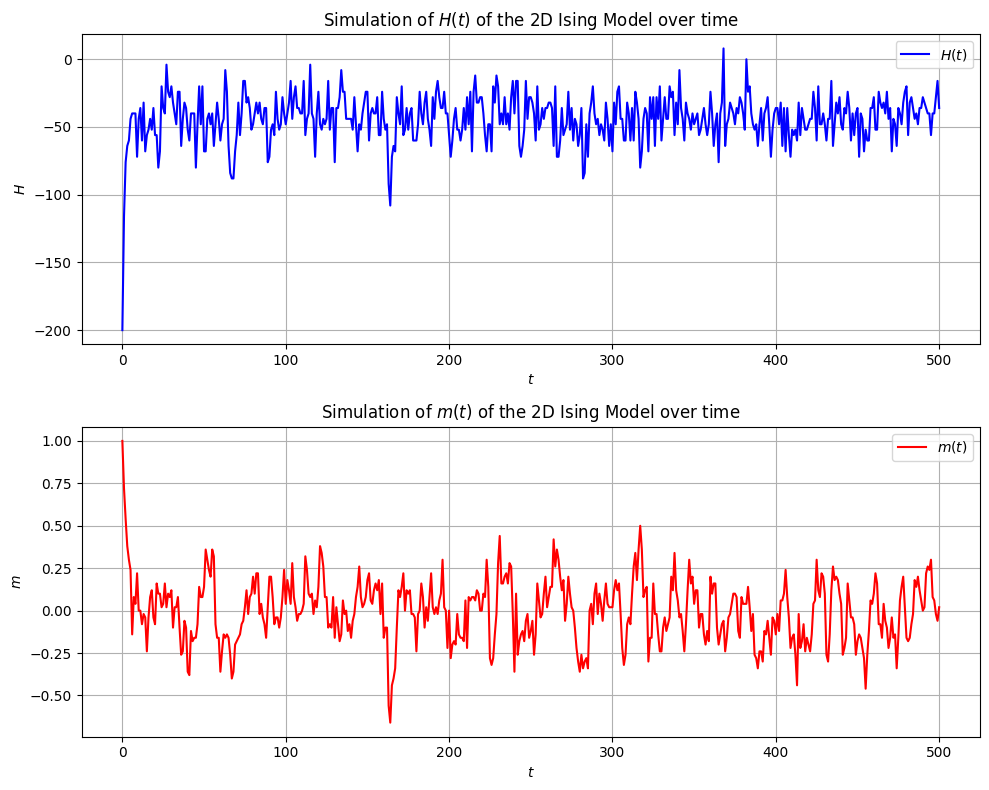

In [5]:
# Ploting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(energy, label='$H(t)$', color='blue')
ax1.set_title('Simulation of $H(t)$ of the 2D Ising Model over time')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$H$')
ax1.legend()
ax1.grid()
ax2.plot(magnetization, label='$m(t)$', color='red')
ax2.set_title('Simulation of $m(t)$ of the 2D Ising Model over time')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$m$')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()


In [9]:
magnetization[0]

1.0

In [15]:
sim_history[0]

array([[ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1, -1,  1, -1, -1,  1],
       [ 1,  1,  1,  1,  1, -1,  1, -1,  1,  1],
       [ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1],
       [ 1,  1, -1,  1,  1,  1,  1,  1, -1,  1],
       [ 1,  1,  1,  1,  1,  1, -1,  1,  1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]], dtype=int32)

In [6]:
def exp(x, a, b, c):
    return a*np.exp(-x/b) + c

popt_e, pcov_e = curve_fit(exp, np.arange(len(energy)), energy, p0=(1, 0.5, 1))
perr_e = np.sqrt(np.diag(pcov_e))

popt_m, pcov_m = curve_fit(exp, np.arange(len(magnetization)), magnetization, p0=(1, 0.5, 1))
perr_m = np.sqrt(np.diag(pcov_m))

print("Monte Carlo correlation time τ based on energy:", popt_e[1], "+-", perr_e[1])
print("Monte Carlo correlation time τ based on magnetization:", popt_m[1], "+-", perr_m[1])

Monte Carlo correlation time τ based on energy: 1.3620247195548099 +- 0.26282833965482627
Monte Carlo correlation time τ based on magnetization: 2.878167019588498 +- 0.702357081298808


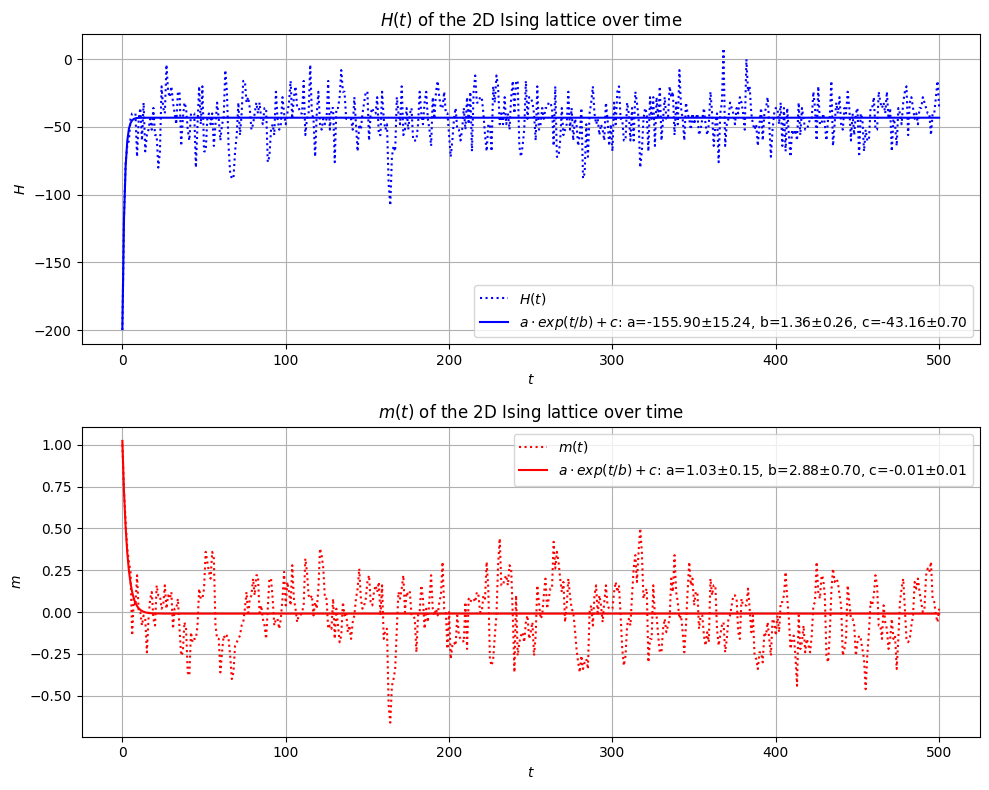

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(energy, label='$H(t)$', color='blue', ls=":")
ax1.plot(exp(np.arange(len(energy)), *popt_e), label=f"$a\\cdot exp(t/b)+c$: a={popt_e[0]:.2f}±{perr_e[0]:.2f}, b={popt_e[1]:.2f}±{perr_e[1]:.2f}, c={popt_e[2]:.2f}±{perr_e[2]:.2f}", color='blue', ls="-")
ax1.set_title('$H(t)$ of the 2D Ising lattice over time')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$H$')
ax1.legend()
ax1.grid()
ax2.plot(magnetization, label='$m(t)$', color='red', ls=":")
ax2.plot(exp(np.arange(len(magnetization)), *popt_m), label=f"$a\\cdot exp(t/b)+c$: a={popt_m[0]:.2f}±{perr_m[0]:.2f}, b={popt_m[1]:.2f}±{perr_m[1]:.2f}, c={popt_m[2]:.2f}±{perr_m[2]:.2f}", color='red', ls="-")
ax2.set_title('$m(t)$ of the 2D Ising lattice over time')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$m$')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()

In [33]:
L = 10
field_constants = np.linspace(0, 10, 100)
M_avg_values = []
M_std_values = []
M_values = np.zeros((100, 200))
for i, h in enumerate(field_constants):
	sim = simulator.MCIsing(10, 10, state="UP", seed=42, h=h)
	sim.run_numpy_output(1000)
	M_values[i,:] = sim.get_magnetization_record()[500+301:]*L*L
	M_avg_values.append(np.mean(M_values[i]))
	M_std_values.append(np.std(M_values[i]))

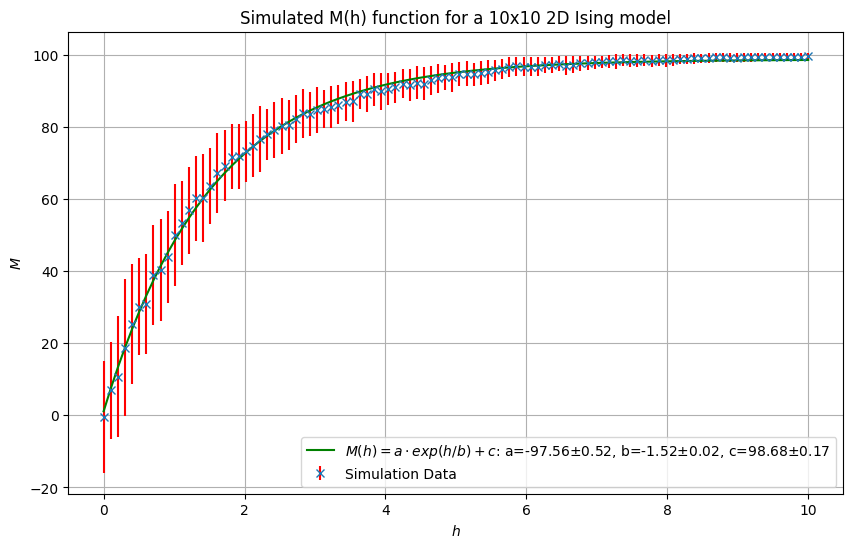

In [34]:
def _exp(x, a, b, c):
    return a*np.exp(x/b) + c

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(field_constants, M_avg_values, yerr=M_std_values, fmt='x', ecolor='r', capthick=1, label='Simulation Data')
popt_M , pcov_M = curve_fit(_exp, field_constants, M_avg_values, p0=(-1, -1, 1))
perr_M = np.sqrt(np.diag(pcov_M))
ax.plot(field_constants, _exp(field_constants, *popt_M), label=f"$M(h)=a\\cdot exp(h/b)+c$: a={popt_M[0]:.2f}±{perr_M[0]:.2f}, b={popt_M[1]:.2f}±{perr_M[1]:.2f}, c={popt_M[2]:.2f}±{perr_M[2]:.2f}", color='green')
ax.set_title('Simulated M(h) function for a 10x10 2D Ising model')
ax.set_xlabel('$h$')
ax.set_ylabel('$M$')
ax.legend(loc="lower right")
plt.grid()
plt.show()


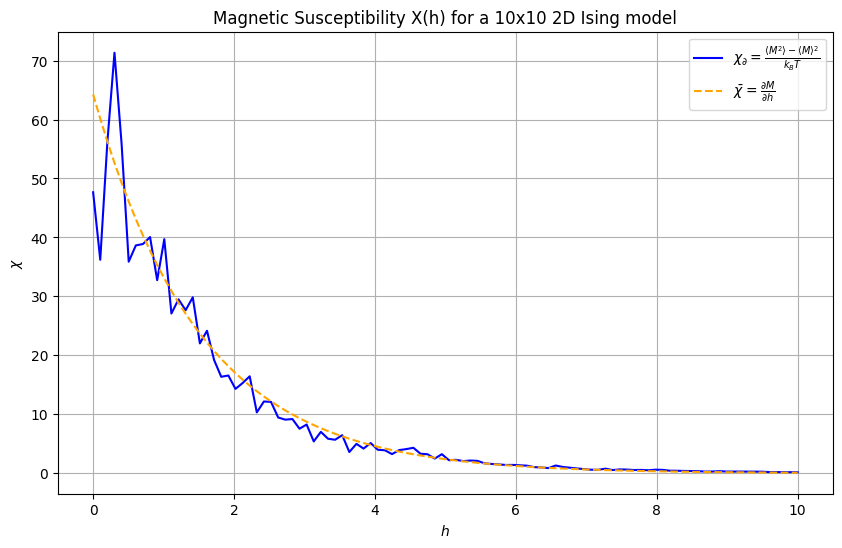

In [35]:
import sympy as sp
h = sp.symbols('h')
a, b, c = sp.symbols('a b c')
M_h = a*sp.exp(h/b) + c
X_sym = M_h.diff(h)
X_num = (np.average(M_values**2 , axis=1)- np.average(M_values, axis=1)**2) / 5
X_sym_values = np.array([
	float(X_sym.subs({a: popt_M[0], b: popt_M[1], c: popt_M[2], h: float(h_val)}).evalf())
	for h_val in field_constants
])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(field_constants, X_num, label='$\\chi_\\partial=\\frac{\\langle M^2 \\rangle - \\langle M \\rangle^2}{k_BT}$', color='blue')
ax.plot(field_constants, X_sym_values, label='$\\bar\\chi=\\frac{\\partial M}{\\partial h}$', color='orange', ls="--")
ax.set_title('Magnetic Susceptibility X(h) for a 10x10 2D Ising model')
ax.set_xlabel('$h$')
ax.set_ylabel('$\\chi$')
ax.legend()
plt.grid()
plt.show()


In [31]:
fc_count = 101
timestep_avg_period = 500
puffer = 300
L = 10
field_constants = np.linspace(-0.1, 0.1, fc_count)
M_values = np.zeros((fc_count, timestep_avg_period))
for i, h in enumerate(field_constants):
	sim = simulator.MCIsing(L, L, state="RANDOM", seed=42, h=h, k_BT=5)
	sim.run_numpy_output(puffer + timestep_avg_period)
	M_values[i,:] = sim.get_magnetization_record()[puffer+1:]
def linear(x, m, c):
	return m*x + c

M_values *= L*L
X_num = (np.average(M_values**2 , axis=1) - np.average(M_values, axis=1)**2) / 5 

popt_l, pcov_l = curve_fit(linear, field_constants, np.average(M_values, axis=1))
perr_l = np.sqrt(np.diag(pcov_l))

print("Derivative of M(h) at h=0:", popt_l[0], "+-", perr_l[0])
print("Susceptibility at h=0 :", X_num[np.where(np.array(field_constants) == 0)[0][0]], "+-", np.std(M_values[np.where(np.array(field_constants) == 0)[0][0]]))

Derivative of M(h) at h=0: 56.61285963435204 +- 2.4970909058286774
Susceptibility at h=0 : 56.9884 +- 16.8802251169823


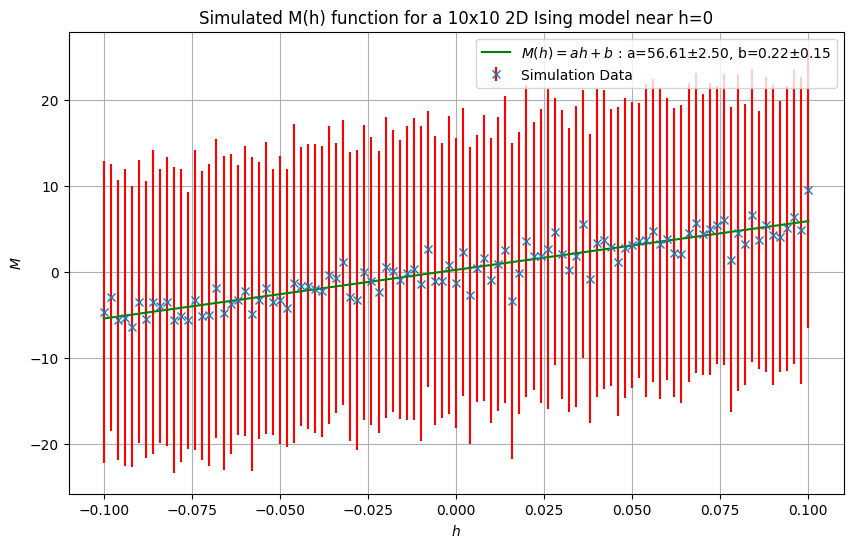

In [23]:
plt.figure(figsize=(10, 6))
plt.errorbar(field_constants, np.average(M_values, axis=1), yerr=np.std(M_values, axis=1), fmt='x', ecolor='r', capthick=1, label='Simulation Data')
plt.plot(field_constants, linear(field_constants, *popt_l), label=f"$M(h)=ah+b$ : a={popt_l[0]:.2f}±{perr_l[0]:.2f}, b={popt_l[1]:.2f}±{perr_l[1]:.2f}", color='green')
plt.title('Simulated M(h) function for a 10x10 2D Ising model near h=0')
plt.xlabel('$h$')
plt.ylabel('$M$')
plt.legend()
plt.grid()
plt.show()

In [14]:
fc_count = 101
timestep_avg_period = 500
puffer = 100
L = 10
field_constants = np.linspace(-0.1, 0.1, fc_count)
M_avg_values = []
M_std_values = []
M_values = np.zeros((fc_count, timestep_avg_period))
for i, h in enumerate(field_constants):
	sim = simulator.MCIsing(L, L, state="RANDOM", seed=42, h=h, k_BT=5)
	sim.run_numpy_output(puffer + timestep_avg_period)
	M_values[i,:] = sim.get_magnetization_record()[puffer+1:]
	M_avg_values.append(np.mean(M_values[i]))
	M_std_values.append(np.std(M_values[i]))

def linear(x, m, c):
	return m*x + c

X_num = (np.average(M_values**2)- np.average(M_values)**2) / 5

popt_l, pcov_l = curve_fit(linear, field_constants, M_avg_values)
perr_l = np.sqrt(np.diag(pcov_l))

print("Derivative of M(h) at h=0:", popt_l[0], "+-", perr_l[0])
print("Numerical susceptibility at h=0 :", X_num)

Derivative of M(h) at h=0: 0.5327596972763463 +- 0.02391630333996026
Numerical susceptibility at h=0 : 0.0059288009345279885


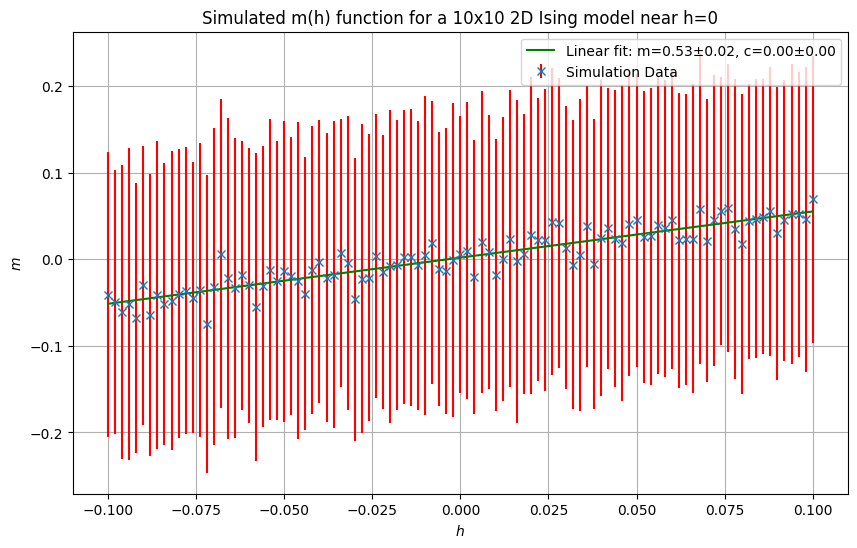

In [15]:
plt.figure(figsize=(10, 6))
plt.errorbar(field_constants, M_avg_values, yerr=M_std_values, fmt='x', ecolor='r', capthick=1, label='Simulation Data')
plt.plot(field_constants, linear(field_constants, *popt_l), label=f"Linear fit: m={popt_l[0]:.2f}±{perr_l[0]:.2f}, c={popt_l[1]:.2f}±{perr_l[1]:.2f}", color='green')
plt.title('Simulated m(h) function for a 10x10 2D Ising model near h=0')
plt.xlabel('$h$')
plt.ylabel('$m$')
plt.legend()
plt.grid()
plt.show()

In [19]:
M_values

array([[-20., -16., -14., ..., -14.,  -4., -14.],
       [ -6.,   2.,   8., ..., -20., -14., -12.],
       [ -8., -12., -12., ..., -22., -18., -10.],
       ...,
       [  2.,  34.,  20., ...,  24.,  28.,  20.],
       [ 16.,  -4., -26., ...,   6.,  -2.,   0.],
       [ 10., -10.,  -8., ...,   2., -14., -10.]])